# Dylan Yaghoutiel -- Final Project -- EDA Notebook:

Link to page with general description of the data: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition


Read the article (https://doi.org/10.1016/j.dib.2019.104344) to see the description of the attributes.

# Importing Libraries and Creating the DataFrame

In [1]:
#import anything you may need over the course of this assigment
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.compose import make_column_transformer
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

from google.colab import files

In [2]:
#add ObesityDataset file to files in Colab and create DataFrame

obesity = pd.read_csv('/content/ObesityDataSet_raw_and_data_sinthetic.csv')

'''
Some important things to note:

'Height' is measured in meters
'Weight' is measured in kilograms
'Age' is measured in years
'FCVC': 1 = Never eats vegetables in meals, 2 = sometimes eats vegetables in meals, 3 = always eats vegetables in meals
'NCP': 1 = eats 1-2 meals daily, 2 = eats 3 meals daily, 3 = eats more than 3 meals daily
'CH2O': 1 = drinks less than 1L of water per day, 2 = drinks 1-2L of water per day, 3 = drinks more than 2L of water per day
'FAF': 0 = no physical activity per week, 1 = 1-2 days physical activity per week, 2 = 2-4 days physical activity per week, 3  4-5 days physical activity per week
'TUE': 0 = 0-2 hours of tech usage per day, 1 = 3-5 hours of tech usage per day, 2 = more than 5 hours tech usage per day
'''

obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
obesity.info()

'''
There are no missing values in the dataset.
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

'\nThere are no missing values in the dataset.\n'

In [4]:
obesity.describe(include = 'all')

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
count,2111,2111.000000,2111.000000,2111.000000,2111,2111,2111.000000,2111.000000,2111,2111,2111.000000,2111,2111.000000,2111.000000,2111,2111,2111
unique,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,4,5,7
top,Male,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,NaN,NaN,NaN,1726,1866,NaN,NaN,1765,2067,NaN,2015,NaN,NaN,1401,1580,351
mean,NaN,24.312600,1.701677,86.586058,NaN,NaN,2.419043,2.685628,NaN,NaN,2.008011,NaN,1.010298,0.657866,NaN,NaN,NaN
std,NaN,6.345968,0.093305,26.191172,NaN,NaN,0.533927,0.778039,NaN,NaN,0.612953,NaN,0.850592,0.608927,NaN,NaN,NaN
min,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,19.947192,1.630000,65.473343,NaN,NaN,2.000000,2.658738,NaN,NaN,1.584812,NaN,0.124505,0.000000,NaN,NaN,NaN
50%,NaN,22.777890,1.700499,83.000000,NaN,NaN,2.385502,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.625350,NaN,NaN,NaN
75%,NaN,26.000000,1.768464,107.430682,NaN,NaN,3.000000,3.000000,NaN,NaN,2.477420,NaN,1.666678,1.000000,NaN,NaN,NaN


# DataFrame Adjustments

In [5]:
#make adjustments to the DataFrame:
#add a 'Height (ft)' column and remove the 'Height' column
obesity['Height (ft)'] = (obesity['Height'] * 3.281).round(2)
obesity.drop(columns = 'Height', inplace = True)

#add a 'Weight (lbs)' column and remove the 'Weight' column
obesity['Weight (lbs)'] = (obesity['Weight'] * 2.205).round(2)
obesity.drop(columns = 'Weight', inplace = True)

#rename the 'Age' column to 'Age (yrs)'
obesity.rename(columns = {'Age': 'Age (yrs)'}, inplace = True)

#move the new columns to where the previously-removed columns were
obesity = obesity[['Gender', 'Age (yrs)', 'Height (ft)', 'Weight (lbs)', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']]

obesity.head()

,Gender,Age (yrs),Height (ft),Weight (lbs),family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,5.32,141.12,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,4.99,123.48,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,5.91,169.78,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,5.91,191.84,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,5.84,198.01,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
#further adjustments to make DataFrame more readable:
#change various column names so we don't have to constantly have to refer to the data's description page for info:
#change 'family_history_with_overweight' to 'Family_History_Overweight'
obesity.rename(columns = {'family_history_with_overweight': 'Family_History_Overweight'}, inplace = True)

#change 'FAVC' to 'High_Caloric_Diet'
obesity.rename(columns = {'FAVC': 'High_Caloric_Diet'}, inplace = True)

#change 'FCVC' to 'Vegetable_Consumption'
obesity.rename(columns = {'FCVC': 'Vegetable_Consumption'}, inplace = True)

#change 'NCP' to 'Number_Daily_Meals'
obesity.rename(columns = {'NCP': 'Number_Daily_Meals'}, inplace = True)

#change 'CAEC' to 'Food_Between_Meals'
obesity.rename(columns = {'CAEC': 'Food_Between_Meals'}, inplace = True)

#change 'SMOKE' to 'Smokes'
obesity.rename(columns = {'SMOKE': 'Smokes'}, inplace = True)

#change 'CH2O' to 'Daily_Water_Consumption'
obesity.rename(columns = {'CH2O': 'Daily_Water_Consumption'}, inplace = True)

#change 'SCC' to 'Monitors_Calories'
obesity.rename(columns = {'SCC': 'Monitors_Calories'}, inplace = True)

#change 'FAF' to 'Physical_Activity'
obesity.rename(columns = {'FAF': 'Physical_Activity'}, inplace = True)

#change 'TUE' to 'Tech_Usage'
obesity.rename(columns = {'TUE': 'Tech_Usage'}, inplace = True)

#change 'CALC' to 'Alcohol_Consumption'
obesity.rename(columns = {'CALC': 'Alcohol_Consumption'}, inplace = True)

#change 'MTRANS' to 'Transportation_Method'
obesity.rename(columns = {'MTRANS': 'Transportation_Method'}, inplace = True)

#change 'NObeyesdad' to 'Weight_Level'
obesity.rename(columns = {'NObeyesdad': 'Weight_Level'}, inplace = True)

In [7]:
#adjust the 'Weight_Level' column so that there are 2 categories (for binary classification): Obese and Not_Obese
#create a mapping for the 2 categories
weight_map = {
    'Insufficient_Weight': 'Not_Obese',
    'Normal_Weight': 'Not_Obese',
    'Overweight_Level_I': 'Not_Obese',
    'Overweight_Level_II': 'Not_Obese',
    'Obesity_Type_I': 'Obese',
    'Obesity_Type_II': 'Obese',
    'Obesity_Type_III': 'Obese'
}

#apply the mapping to the 'Weight_Level' column
obesity['Weight_Level'] = obesity['Weight_Level'].replace(weight_map)

In [8]:
#add a BMI column (we will mainly use BMI as the target variable since it depicts a person's level of obesity (or non-obesity))
obesity['BMI'] = ((obesity['Weight (lbs)'] * 703) / ((obesity['Height (ft)'] * 12) ** 2)).round(2)

In [9]:
#round the segmented columns (eg. 0, 1, 2, 3) to the nearest whole number since, for some reason, some values are decimal
obesity['Vegetable_Consumption'] = obesity['Vegetable_Consumption'].round(0)
obesity['Number_Daily_Meals'] = obesity['Number_Daily_Meals'].round(0)
obesity['Daily_Water_Consumption'] = obesity['Daily_Water_Consumption'].round(0)
obesity['Physical_Activity'] = obesity['Physical_Activity'].round(0)
obesity['Tech_Usage'] = obesity['Tech_Usage'].round(0)

# Legend to Refer to

In [10]:
'''
*****Some important things to note*****

'Vegetable_Consumption': 1 = Never eats vegetables in meals, 2 = sometimes eats vegetables in meals, 3 = always eats vegetables in meals

'Number_Daily_Meals': 1 = eats 1-2 meals daily, 2 = eats 3 meals daily, 3 = eats more than 3 meals daily

'Daily_Water_Consumption': 1 = drinks less than 1L of water per day, 2 = drinks 1-2L of water per day, 3 = drinks more than 2L of water per day

'Physical_Activity': 0 = no physical activity per week, 1 = 1-2 days physical activity per week, 2 = 2-4 days physical activity per week, 3  4-5 days physical activity per week

'Tech_Usage': 0 = 0-2 hours of tech usage per day, 1 = 3-5 hours of tech usage per day, 2 = more than 5 hours tech usage per day

'''

obesity.head()

,Gender,Age (yrs),Height (ft),Weight (lbs),Family_History_Overweight,High_Caloric_Diet,Vegetable_Consumption,Number_Daily_Meals,Food_Between_Meals,Smokes,Daily_Water_Consumption,Monitors_Calories,Physical_Activity,Tech_Usage,Alcohol_Consumption,Transportation_Method,Weight_Level,BMI
0,Female,21.0,5.32,141.12,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Not_Obese,24.34
1,Female,21.0,4.99,123.48,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Not_Obese,24.21
2,Male,23.0,5.91,169.78,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Not_Obese,23.73
3,Male,27.0,5.91,191.84,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Not_Obese,26.81
4,Male,22.0,5.84,198.01,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Not_Obese,28.34


In [11]:
obesity.describe()

,Age (yrs),Height (ft),Weight (lbs),Vegetable_Consumption,Number_Daily_Meals,Daily_Water_Consumption,Physical_Activity,Tech_Usage,BMI
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,5.583306,190.922473,2.423496,2.687826,2.014685,1.006632,0.664614,29.698432
std,6.345968,0.306084,57.751478,0.583905,0.809680,0.688616,0.895462,0.674009,8.011045
min,14.000000,4.760000,86.000000,1.000000,1.000000,1.000000,0.000000,0.000000,13.020000
25%,19.947192,5.350000,144.370000,2.000000,3.000000,2.000000,0.000000,0.000000,24.335000
50%,22.777890,5.580000,183.020000,2.000000,3.000000,2.000000,1.000000,1.000000,28.720000
75%,26.000000,5.800000,236.885000,3.000000,3.000000,2.000000,2.000000,1.000000,35.990000
max,61.000000,6.500000,381.460000,3.000000,4.000000,3.000000,3.000000,2.000000,50.750000


In [12]:
obesity.shape

(2111, 18)

In [13]:
obesity.head()

,Gender,Age (yrs),Height (ft),Weight (lbs),Family_History_Overweight,High_Caloric_Diet,Vegetable_Consumption,Number_Daily_Meals,Food_Between_Meals,Smokes,Daily_Water_Consumption,Monitors_Calories,Physical_Activity,Tech_Usage,Alcohol_Consumption,Transportation_Method,Weight_Level,BMI
0,Female,21.0,5.32,141.12,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Not_Obese,24.34
1,Female,21.0,4.99,123.48,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Not_Obese,24.21
2,Male,23.0,5.91,169.78,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Not_Obese,23.73
3,Male,27.0,5.91,191.84,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Not_Obese,26.81
4,Male,22.0,5.84,198.01,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Not_Obese,28.34


# Exploratory Data Analysis (EDA)

First, see how well each numeric column separate obese individuals and non-obese individuals:

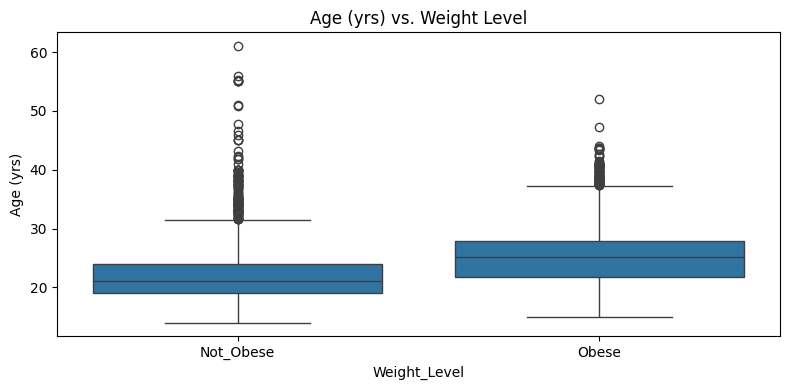

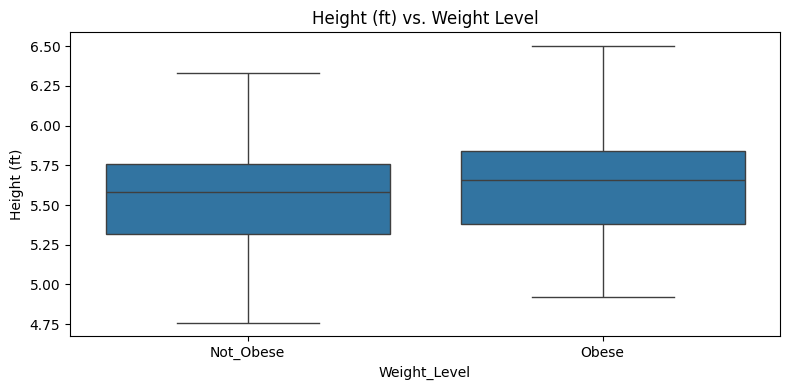

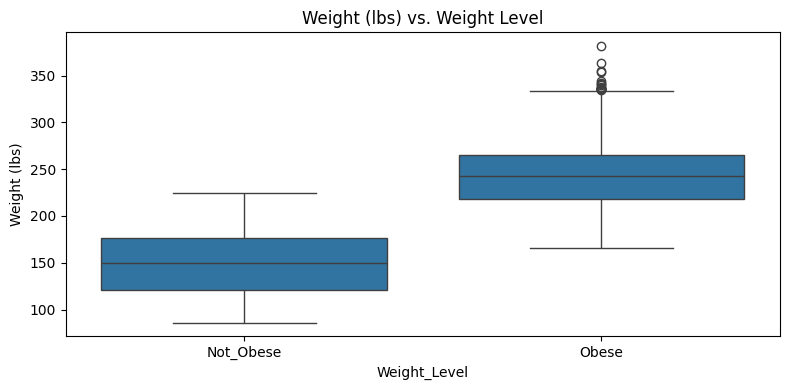

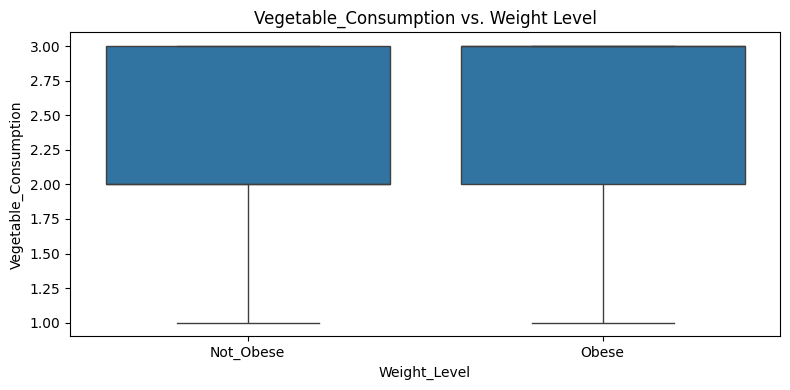

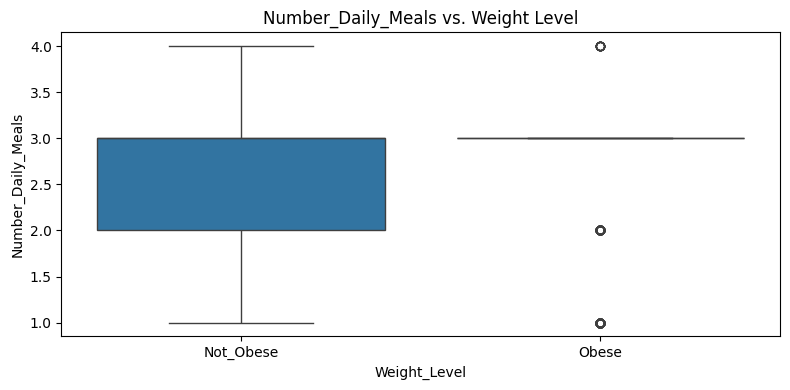

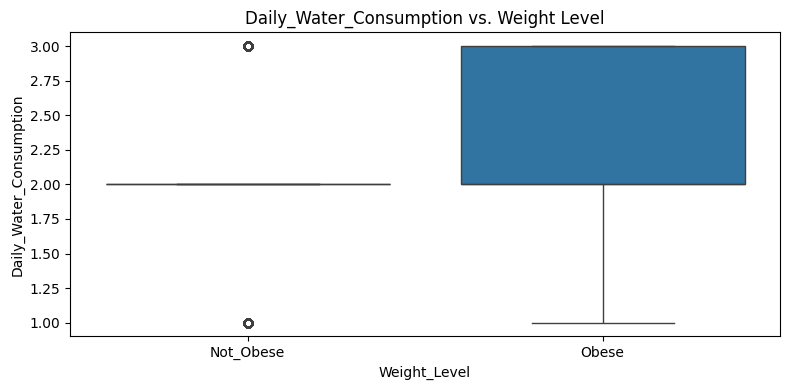

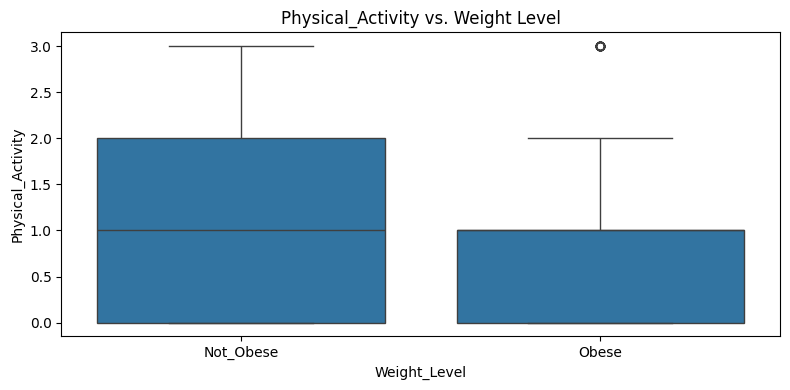

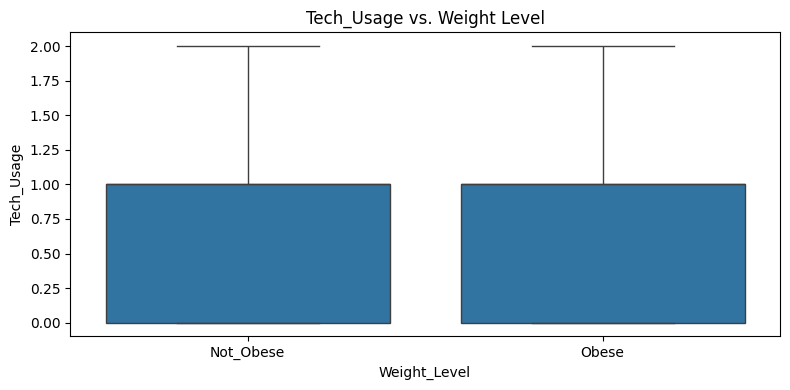

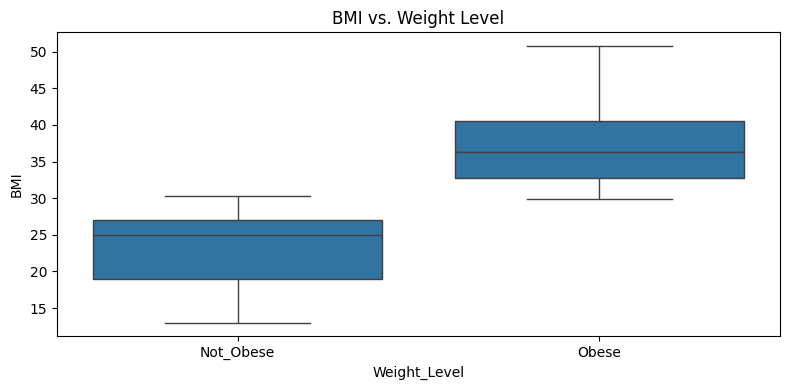

In [14]:
#loop through all numeric columns in the DataFrame and make boxplots with classification as the 'x'
for col in obesity.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=obesity, x='Weight_Level', y=col)
    plt.title(f'{col} vs. Weight Level')
    plt.tight_layout()
    plt.show()

Numeric features I want to include in the model based on the EDA so far:

'Age (yrs)'

Now, explore the categorical variables (including the ones expressed numerically that did not yield clear results in the previous cell):

The numerically-represented variables that I want to explore against BMI are Vegetale_Consumption, Number_Daily_Meals, Daily_Water_Consumption, Physical_Activity, and Tech_Usage.

Since categorical variables take away the numeric element needed for boxplots, I will use BMI as a proxy for my measure of Weight_Level. That way, there is the numeric element that will allow me to continue using box plots for my EDA.

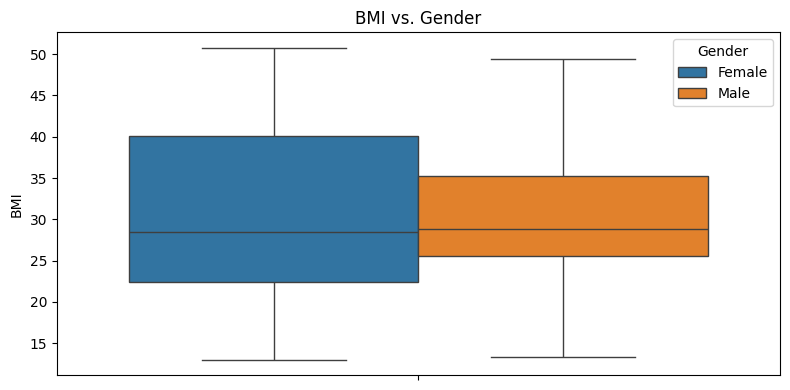

In [15]:
#BMI vs. Gender
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Gender', y='BMI')
plt.title('BMI vs. Gender')
plt.tight_layout()
plt.show()

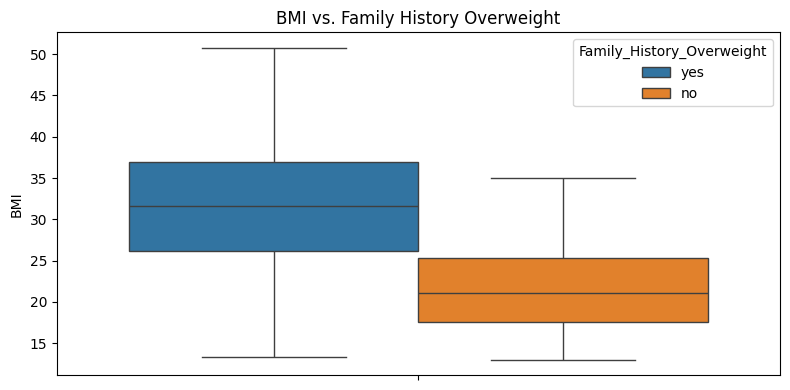

In [17]:
#BMI vs. family_history_overweight
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Family_History_Overweight', y='BMI')
plt.title('BMI vs. Family History Overweight')
plt.tight_layout()
plt.show()

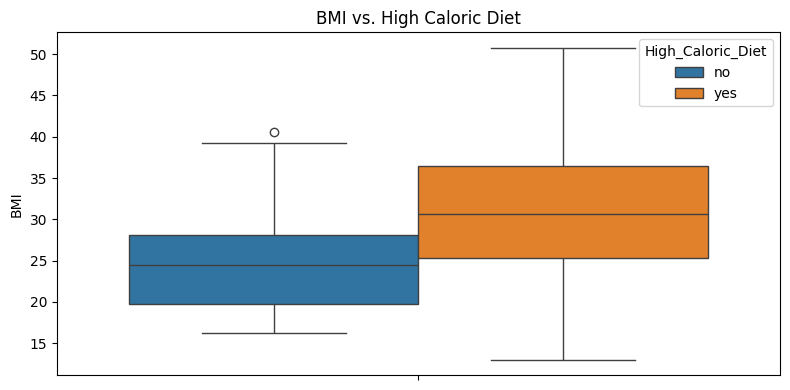

In [18]:
#BMI vs. High_Caloric_Diet
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='High_Caloric_Diet', y='BMI')
plt.title('BMI vs. High Caloric Diet')
plt.tight_layout()
plt.show()

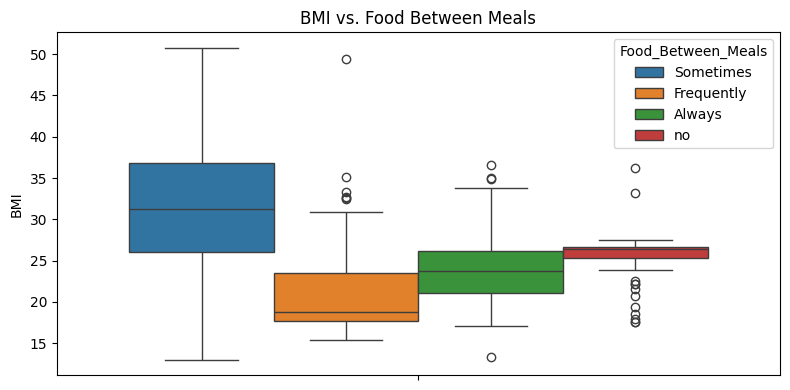

In [19]:
#BMI vs. Food_Between_Meals
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Food_Between_Meals', y='BMI')
plt.title('BMI vs. Food Between Meals')
plt.tight_layout()
plt.show()

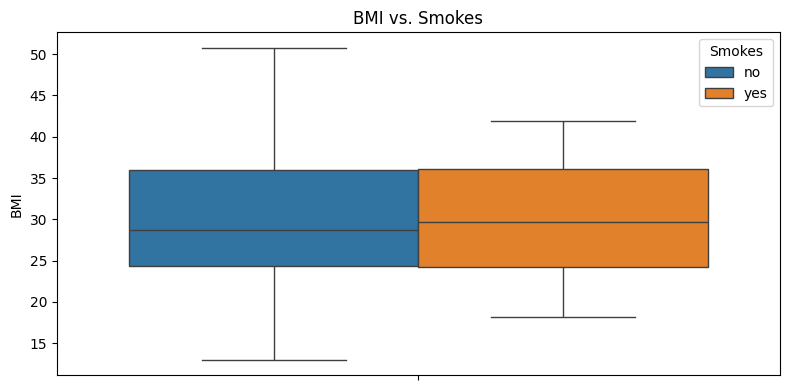

In [20]:
#BMI vs. Smokes
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Smokes', y='BMI')
plt.title('BMI vs. Smokes')
plt.tight_layout()
plt.show()

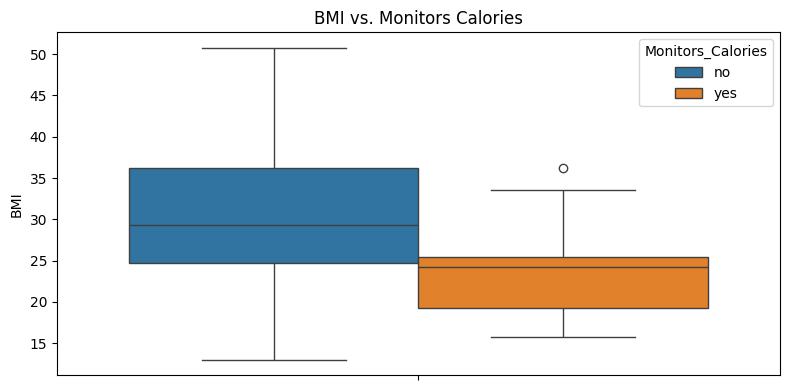

In [21]:
#BMI vs. Monitors_Calories
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Monitors_Calories', y='BMI')
plt.title('BMI vs. Monitors Calories')
plt.tight_layout()
plt.show()

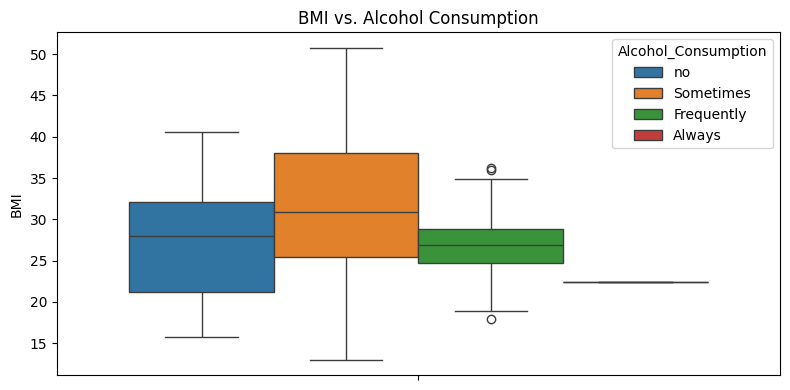

In [22]:
#BMI vs. Alcohol_Consumption
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Alcohol_Consumption', y='BMI')
plt.title('BMI vs. Alcohol Consumption')
plt.tight_layout()
plt.show()

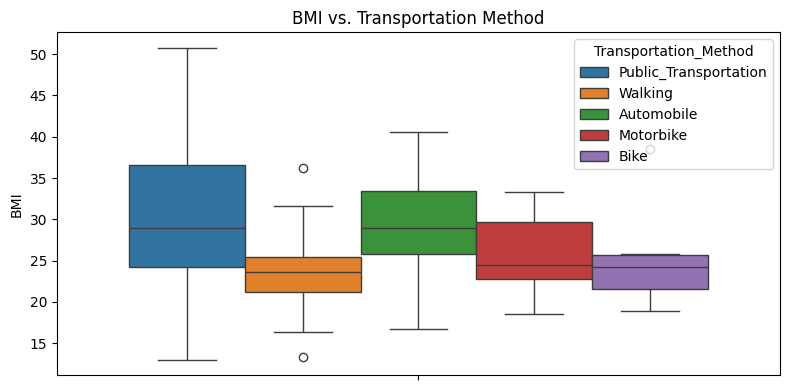

In [23]:
#BMI vs. Transportation_Method
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Transportation_Method', y='BMI')
plt.title('BMI vs. Transportation Method')
plt.tight_layout()
plt.show()

Categorical features I want to include in the model based on the EDA:

'Family_History_Overweight', 'High_Caloric_Diet', 'Food_Between_Meals', 'Monitors_Calories'

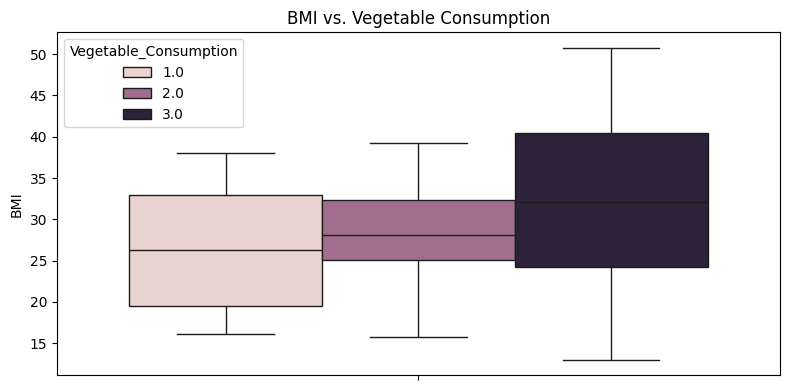

In [27]:
#BMI vs. Vegetale_Consumption
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Vegetable_Consumption', y='BMI')
plt.title('BMI vs. Vegetable Consumption')
plt.tight_layout()
plt.show()

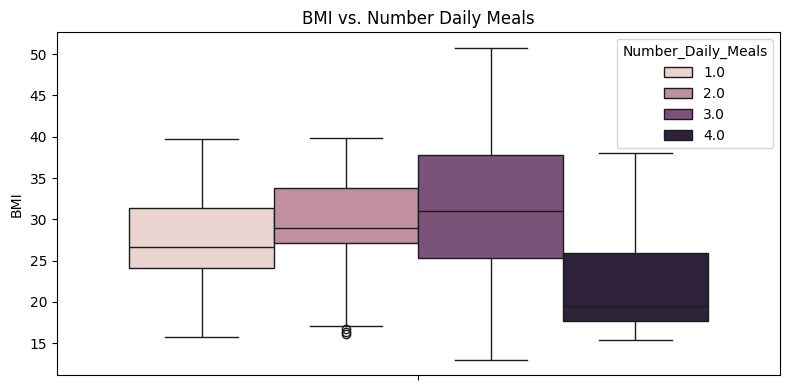

In [28]:
#BMI vs. Number_Daily_Meals
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Number_Daily_Meals', y='BMI')
plt.title('BMI vs. Number Daily Meals')
plt.tight_layout()
plt.show()

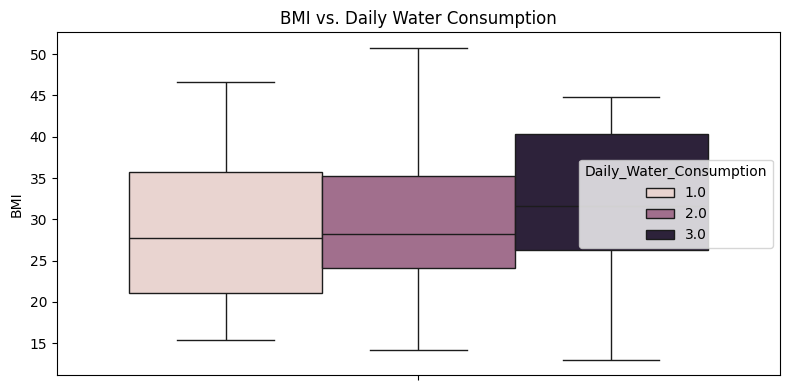

In [29]:
#BMI vs. Daily_Water_Consumption
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Daily_Water_Consumption', y='BMI')
plt.title('BMI vs. Daily Water Consumption')
plt.tight_layout()
plt.show()

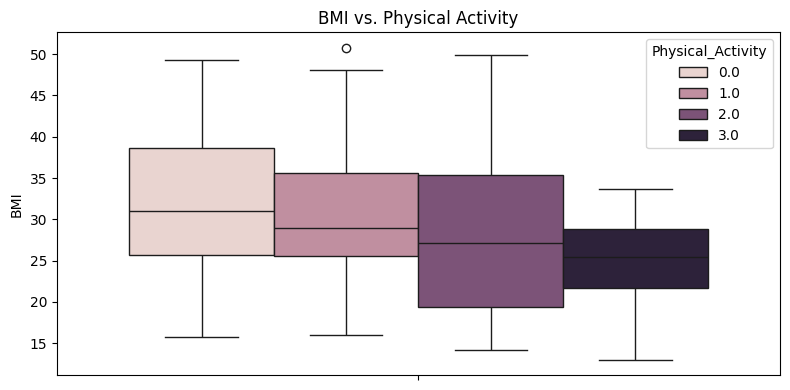

In [30]:
#BMI vs. Physical_Activity
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Physical_Activity', y='BMI')
plt.title('BMI vs. Physical Activity')
plt.tight_layout()
plt.show()

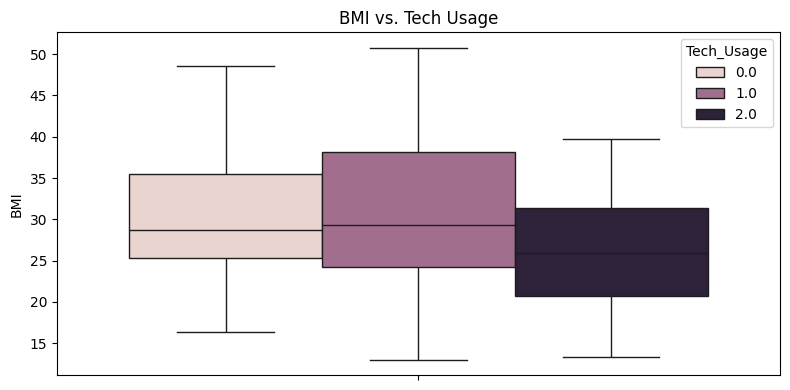

In [31]:
#BMI vs. Tech_Usage
plt.figure(figsize=(8, 4))
sns.boxplot(data=obesity, hue='Tech_Usage', y='BMI')
plt.title('BMI vs. Tech Usage')
plt.tight_layout()
plt.show()

# The Final Verdict

The final list of features I would like to include in my predictive models...

Numeric:
'Age (yrs)'


Categorical:
'Family_History_Overweight', 'High_Caloric_Diet', 'Food_Between_Meals', 'Monitors_Calories'